# **Lab Assignment 3 - Artificial Intelligence - Computer Vision Assignment (EfficientNetB0)**

**Submitted by**

      Md. Miskat Hossain
      2021-2-60-109
      Department of Computer Science & Engineering
      East West University
**Submitted to**

      Dr. Mohammad Rifat Ahmmad Rashid
      Assistant Professor
      Department of Computer Science & Engineering
      East West University

#Task 01: Introduction to the problem statement and your approach

The dataset contains 1006 leaf images grouped according to their nutritional deficiencies (Boron, Iron, Potasium, Calcium, Magnesium, Manganese, Nitrogen and others). CoLeaf dataset contain images that facilitate training and validation during the utilization of deep learning algorithms for coffee plant leaf nutritional deficiencies recognition and classification.

We used this dataset to train our models for object classification and subsequently evaluated their performance. Specifically, we employed EfficientNetB0 and ResNet50 architectures for the task. Here EfficientNetB0 is implemented in this report. Other report contains ResNet50 implementation and its analyzation.

**Model Libraries**

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random
from collections import Counter

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
from cycler import cycler
import textwrap

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Task 02: Loading dataset

In [2]:
# Create helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot


BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
# Walk through each directory

import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to your Google Drive folder where the shared folder is mounted
google_drive_path = '/content/drive/My Drive/'

# Define the path to your dataset in Google Drive
data_dir_drive = google_drive_path + 'CoLeaf Assignment3/'

walk_through_dir(data_dir_drive);

--2024-05-23 17:57:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-23 17:57:23 (73.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]

Mounted at /content/drive
There are 2 directories and 2 images in '/content/drive/My Drive/CoLeaf Assignment3/'.
There are 10 directories and 0 images in '/content/drive/My Drive/CoLeaf Assignment3/test'.
There are 0 directories and 13 images in '/content/drive/My Drive/CoLeaf Assignment3/test/manganese-Mn'.
There are 0 directories and 15 images in '/content/drive/My Drive/C

In [3]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    random.seed(seed)

    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [4]:
def create_image_dataframe(dataset_path: str) -> pd.DataFrame:
    image_dir = Path(dataset_path)

    # Get filepaths for various extensions
    filepaths = list(image_dir.glob(r'**/*.JPG')) + \
                list(image_dir.glob(r'**/*.jpg')) + \
                list(image_dir.glob(r'**/*.png')) + \
                list(image_dir.glob(r'**/*.PNG'))

    # Extract labels from filepaths
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    # Convert lists to Series
    filepaths_series = pd.Series(filepaths, name='Filepath').astype(str)
    labels_series = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels into a DataFrame
    image_df = pd.concat([filepaths_series, labels_series], axis=1)

    return image_df

#

train_dataset = data_dir_drive + "/train"
test_dataset = data_dir_drive + "/test"

test_df = create_image_dataframe(test_dataset)
train_df = create_image_dataframe(train_dataset)

In [5]:
test_df

Filepath         Label
0    /content/drive/My Drive/CoLeaf Assignment3/tes...  manganese-Mn
1    /content/drive/My Drive/CoLeaf Assignment3/tes...  manganese-Mn
2    /content/drive/My Drive/CoLeaf Assignment3/tes...  manganese-Mn
3    /content/drive/My Drive/CoLeaf Assignment3/tes...  manganese-Mn
4    /content/drive/My Drive/CoLeaf Assignment3/tes...  manganese-Mn
..                                                 ...           ...
184  /content/drive/My Drive/CoLeaf Assignment3/tes...       boron-B
185  /content/drive/My Drive/CoLeaf Assignment3/tes...       boron-B
186  /content/drive/My Drive/CoLeaf Assignment3/tes...       boron-B
187  /content/drive/My Drive/CoLeaf Assignment3/tes...       boron-B
188  /content/drive/My Drive/CoLeaf Assignment3/tes...       boron-B

[189 rows x 2 columns]

**Distribution of classes in Dataset**

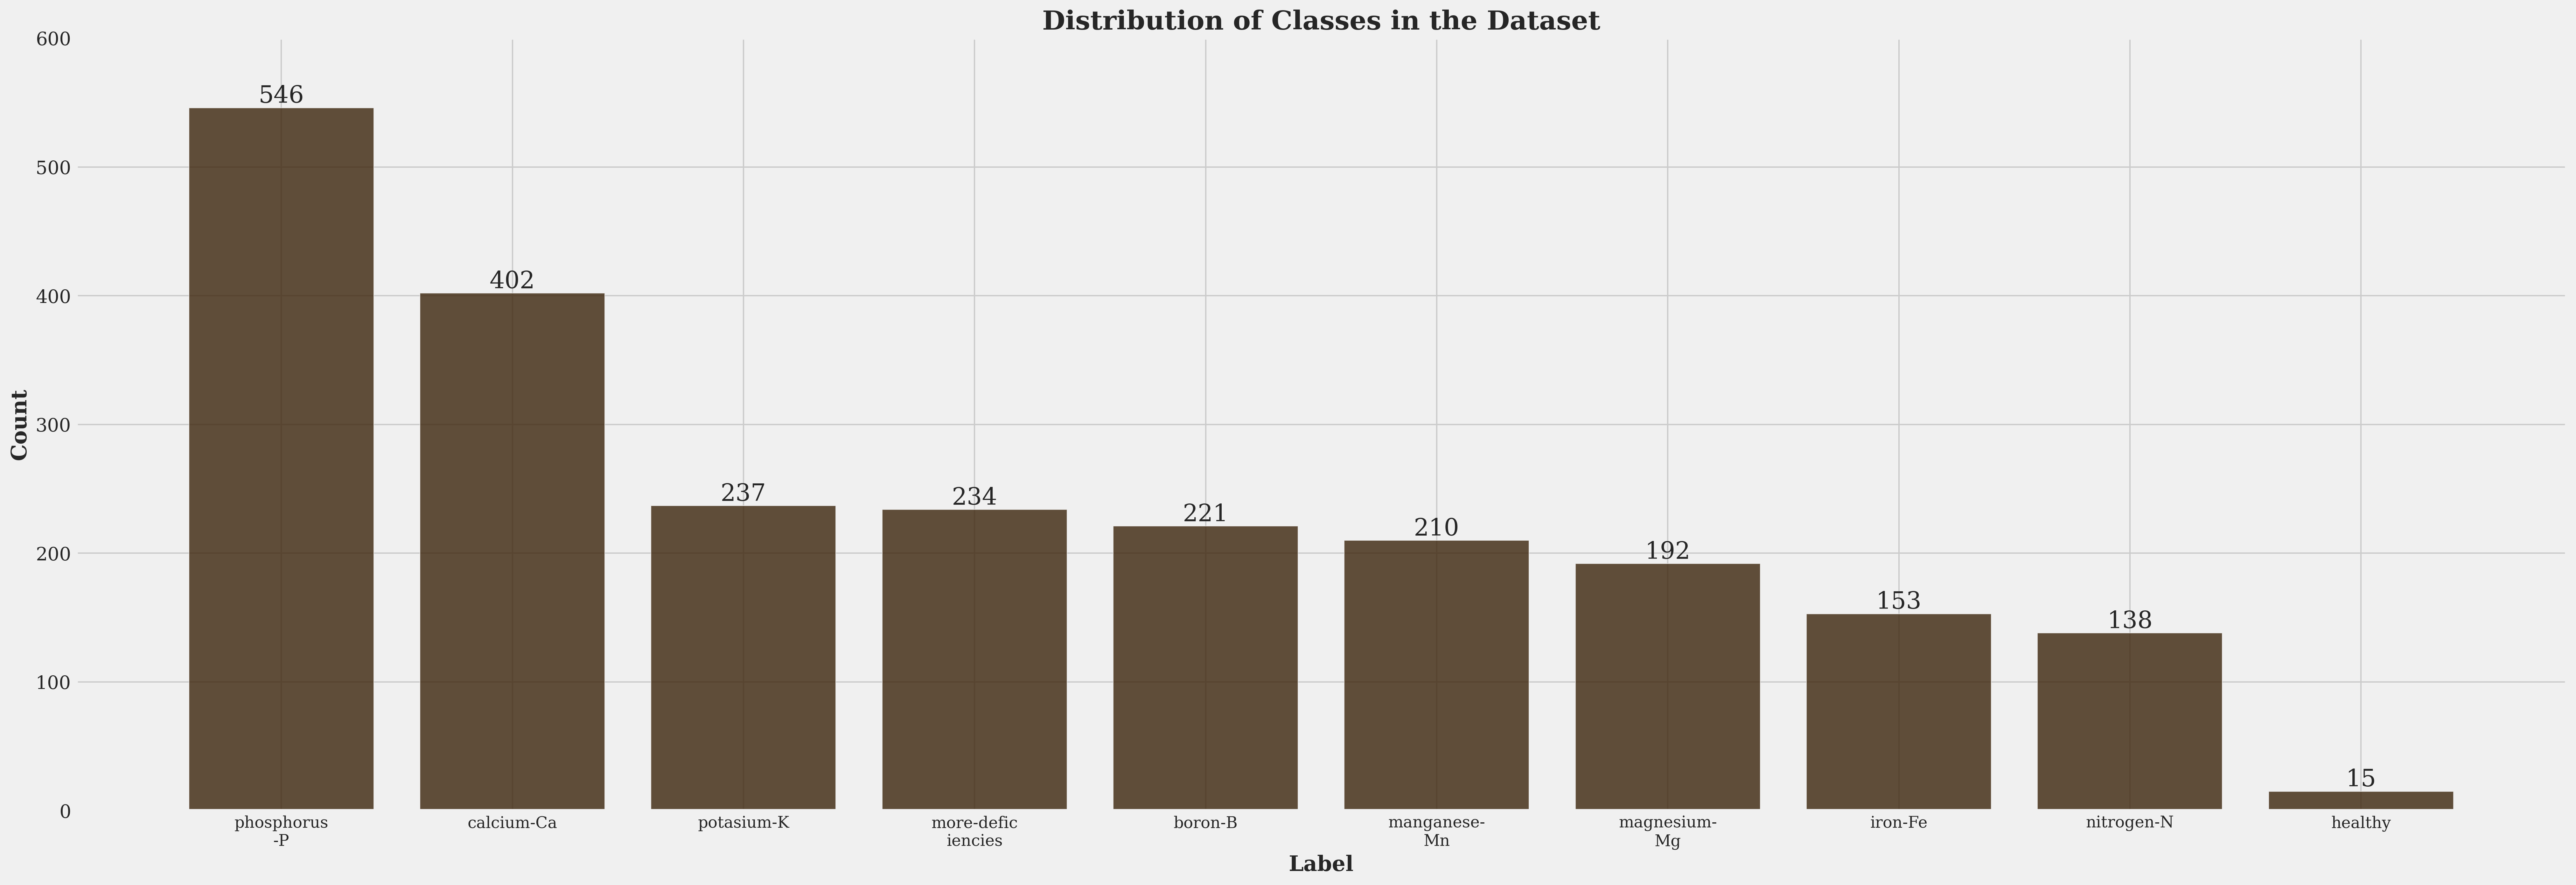

In [6]:
plt.style.use('fivethirtyeight')

# Get the labels
label_counts = train_df['Label'].value_counts()[:]

# Create a cycler object using the desired colors
color_cycler = (cycler(color=["#3B240B"]))  # Darker coffee brown color

# Set the property cycle of the axes to the created cycler object
plt.rc('axes', prop_cycle=color_cycler)

# Other styling options
plt.rc("font", family="serif", size=18.)
plt.rc("savefig", dpi=200)
plt.rc("legend", loc="best", fontsize="medium", fancybox=True, framealpha=0.5)
plt.rc("lines", linewidth=2.5, markersize=10, markeredgewidth=2.5)

plt.figure(figsize=(30, 10), dpi=300)  # Increase figure size
bars = plt.bar(label_counts.index, label_counts.values, alpha=0.8)
plt.title('Distribution of Classes in the Dataset', fontsize=20, fontweight='bold')
plt.xlabel('Label', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=16, fontweight='bold')

# Wrap x-labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, 10)) for label in label_counts.index]
plt.xticks(range(len(wrapped_labels)), wrapped_labels, fontsize=12, ha='center')  # Change alignment to 'center'

plt.yticks(fontsize=14)

# Adjust y limit to avoid overlapping
plt.ylim(0, max(label_counts) * 1.1)  # Set y limit 10% higher than the max value

# Add value annotations on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, int(yval), ha='center', va='bottom')

plt.show()


Visualizing images from the dataset

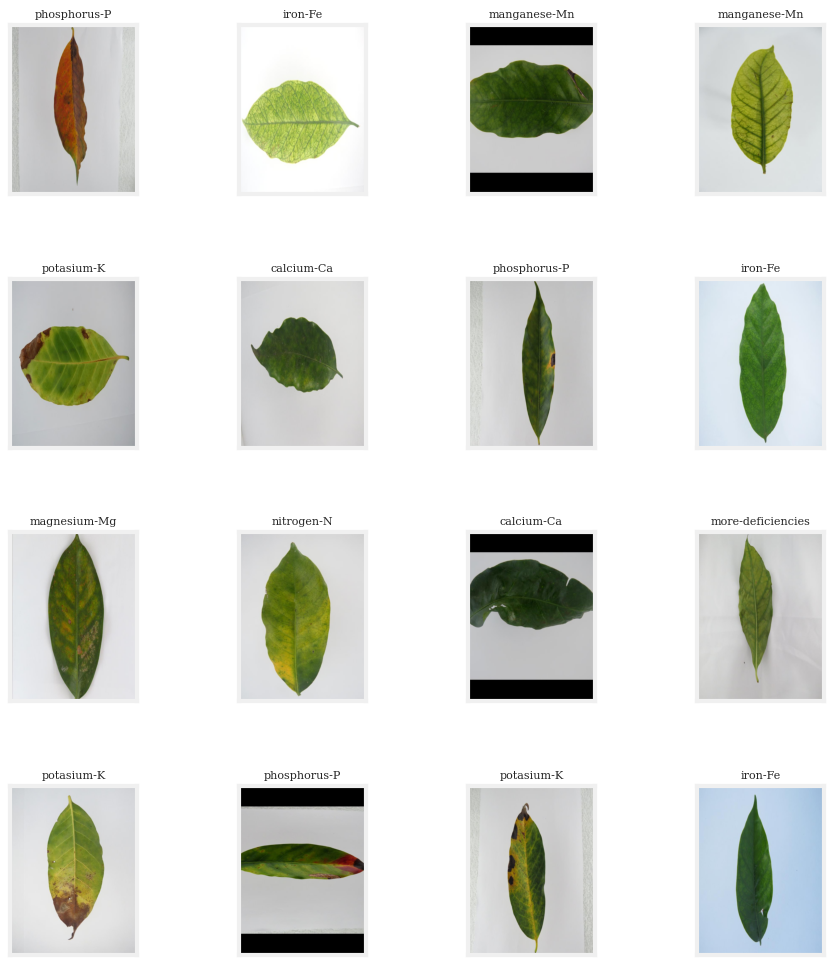

In [7]:
# Set title size and figure background color
plt.rcParams['axes.titlesize'] = 'small'  # Adjust as needed
plt.rcParams['figure.facecolor'] = 'white'  # Set figure background color to white

# Display 16 pictures of the dataset with their labels
random_index = np.random.randint(0, len(train_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[random_index[i]]))
    title = train_df.Label[random_index[i]]
    ax.set_title("\n".join(textwrap.wrap(title, 20)), fontsize=8)  # Wrap long titles
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase vertical space between subplots
plt.show()


#Task 03: Data Proprocessing

In [8]:
# Separate in train and test data
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

In [9]:
from sklearn.model_selection import train_test_split

# Shuffle your dataframe for randomness
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Stratified Split
train_df, val_df = train_test_split(train_df, test_size=0.3, stratify=train_df['Label'])

# Now use train_df with train_images generator and val_df with val_images generator without the subset parameter
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1643 validated image filenames belonging to 10 classes.
Found 705 validated image filenames belonging to 10 classes.
Found 189 validated image filenames belonging to 10 classes.


In [10]:
# Function to get distribution from the generator
def get_distribution(generator):
    # Counting occurrences for each class
    counter = Counter(generator.classes)
    max_val = float(max(counter.values()))
    return {k: v/max_val for k, v in counter.items()}

# Print distributions
print(get_distribution(train_images))
print(get_distribution(val_images))


{1: 0.7356020942408377, 8: 1.0, 0: 0.40575916230366493, 9: 0.43455497382198954, 5: 0.38481675392670156, 6: 0.4293193717277487, 7: 0.25392670157068065, 4: 0.3507853403141361, 3: 0.2801047120418848, 2: 0.02617801047120419}
{3: 0.2804878048780488, 9: 0.4329268292682927, 5: 0.38414634146341464, 8: 1.0, 0: 0.4024390243902439, 7: 0.25, 6: 0.4268292682926829, 1: 0.7378048780487805, 2: 0.03048780487804878, 4: 0.35365853658536583}


In [11]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

#Task 04: Model architecture and rationale for choosing specific models.

We have used EfficientNetB0 architecture for object classification.

In [12]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [13]:
# Create checkpoint callback
checkpoint_path = "mld_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [14]:
from keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


#Task 04: Training process, including any hyperparameter tuning

In [15]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile with custom F1-Score
model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', f1_score]
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "mld_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/mld_classification/20240523-175812
Epoch 1/100
52/52 [==============================] - 562s 11s/step - loss: 2.6309 - accuracy: 0.1923 - f1_score: 0.0400 - val_loss: 2.2106 - val_accuracy: 0.2652 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/100
52/52 [==============================] - 19s 359ms/step - loss: 2.1503 - accuracy: 0.2435 - f1_score: 0.0524 - val_loss: 1.9908 - val_accuracy: 0.3007 - val_f1_score: 0.0460 - lr: 0.0010
Epoch 3/100
52/52 [==============================] - 18s 351ms/step - loss: 2.0684 - accuracy: 0.2581 - f1_score: 0.1248 - val_loss: 1.9539 - val_accuracy: 0.3560 - val_f1_score: 0.1026 - lr: 0.0010
Epoch 4/100
52/52 [==============================] - 23s 450ms/step - loss: 1.9807 - accuracy: 0.2879 - f1_score: 0.2050 - val_loss: 1.8956 - val_accuracy: 0.3064 - val_f1_score: 0.2422 - lr: 0.0010
Epoch 5/100
52/52 [==============================] - 19s 358ms/step - loss: 1.9431 - accuracy: 0.2988 - f1_score: 0.212

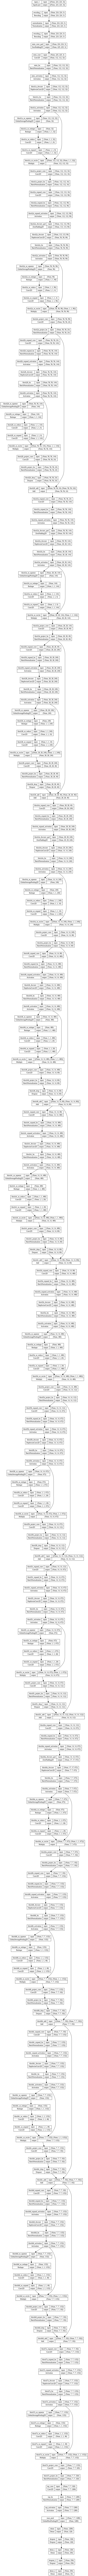

In [16]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
model.save_weights('mango_leaf_disease_ResNet50.h5')

#Task 05: Evaluation metrics and results with visualizations.

We have seen Precision, F1-score and recall. Based on them, we evaluate the performance of our model.

In [18]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))



Test Loss: 1.37075
Test Accuracy: 53.44%


In [19]:
import os

file_size = os.path.getsize('mango_leaf_disease_ResNet50.h5') / (1024 * 1024)  # Convert bytes to MB
print(f"Model file size: {file_size:.2f} MB")

Model file size: 16.72 MB


In [20]:
total_params = model.count_params()
print(f"Total parameters: {total_params}")

Total parameters: 4249133


Visualizing loss and accuracy curves

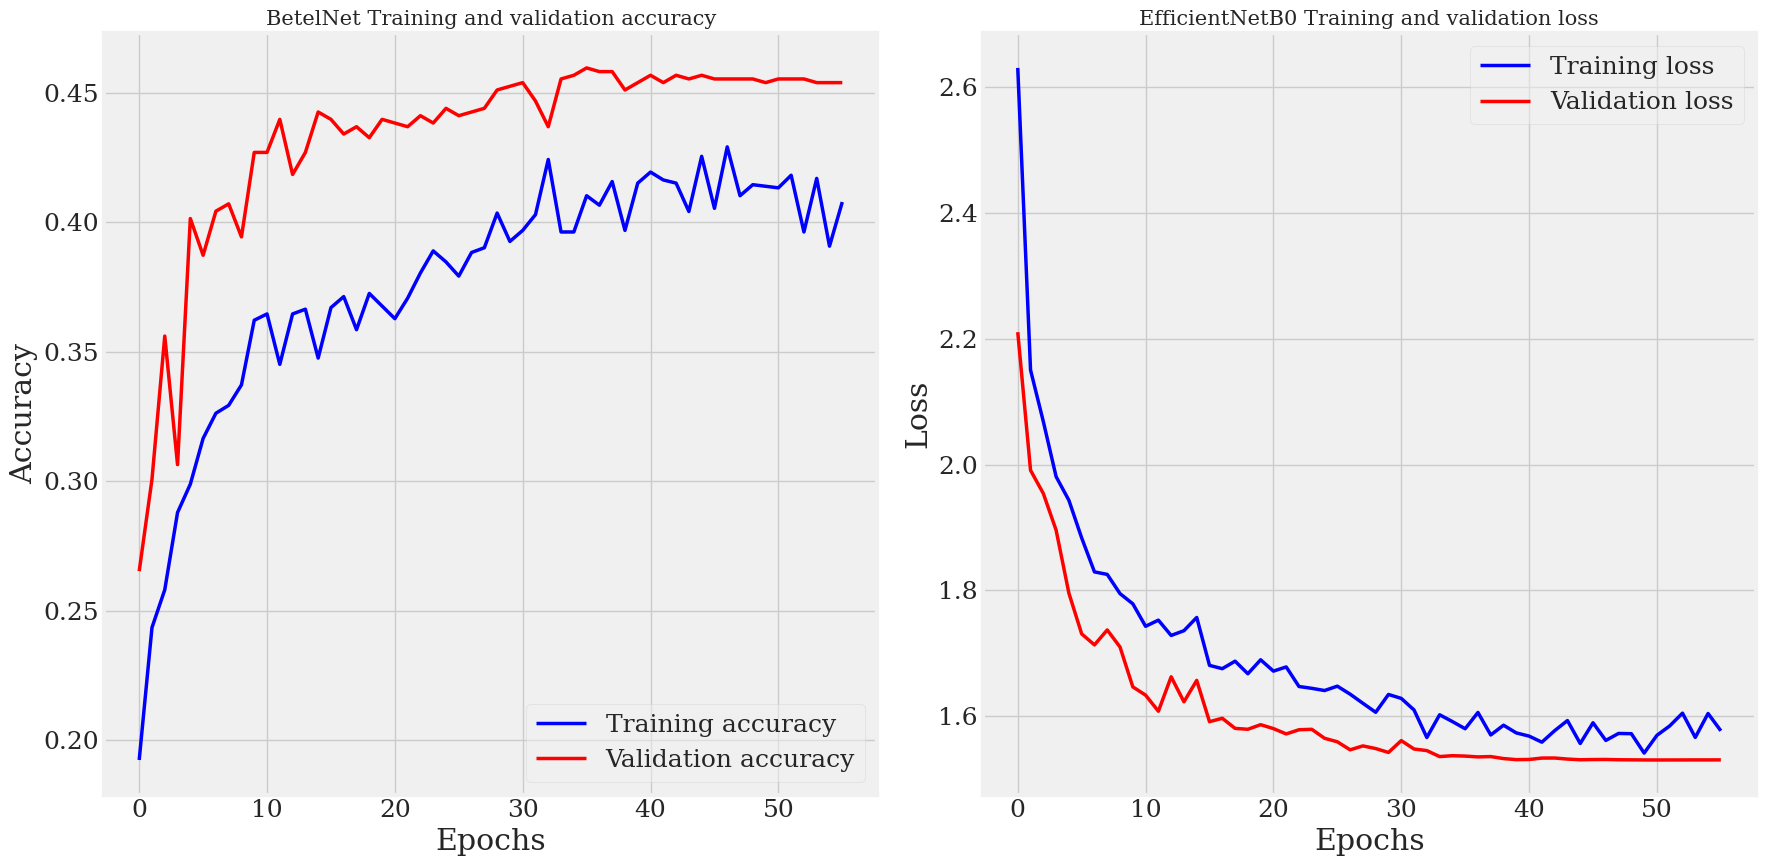

In [30]:
# Extracting F1-score from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))  # Create a 1x3 grid of plots

# Plot accuracy
ax1.plot(epochs, accuracy, 'b', label='Training accuracy', linewidth=2.5)
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy', linewidth=2.5)
ax1.set_title('BetelNet Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(epochs, loss, 'b', label='Training loss', linewidth=2.5)
ax2.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=2.5)
ax2.set_title('EfficientNetB0 Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()



plt.tight_layout()  # Adjust the padding between and around the subplots
plt.show()


#Prediction test

In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the labelz
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

6/6 [==============================] - 3s 223ms/step
The first 5 predictions: ['boron-B', 'manganese-Mn', 'more-deficiencies', 'calcium-Ca', 'manganese-Mn']


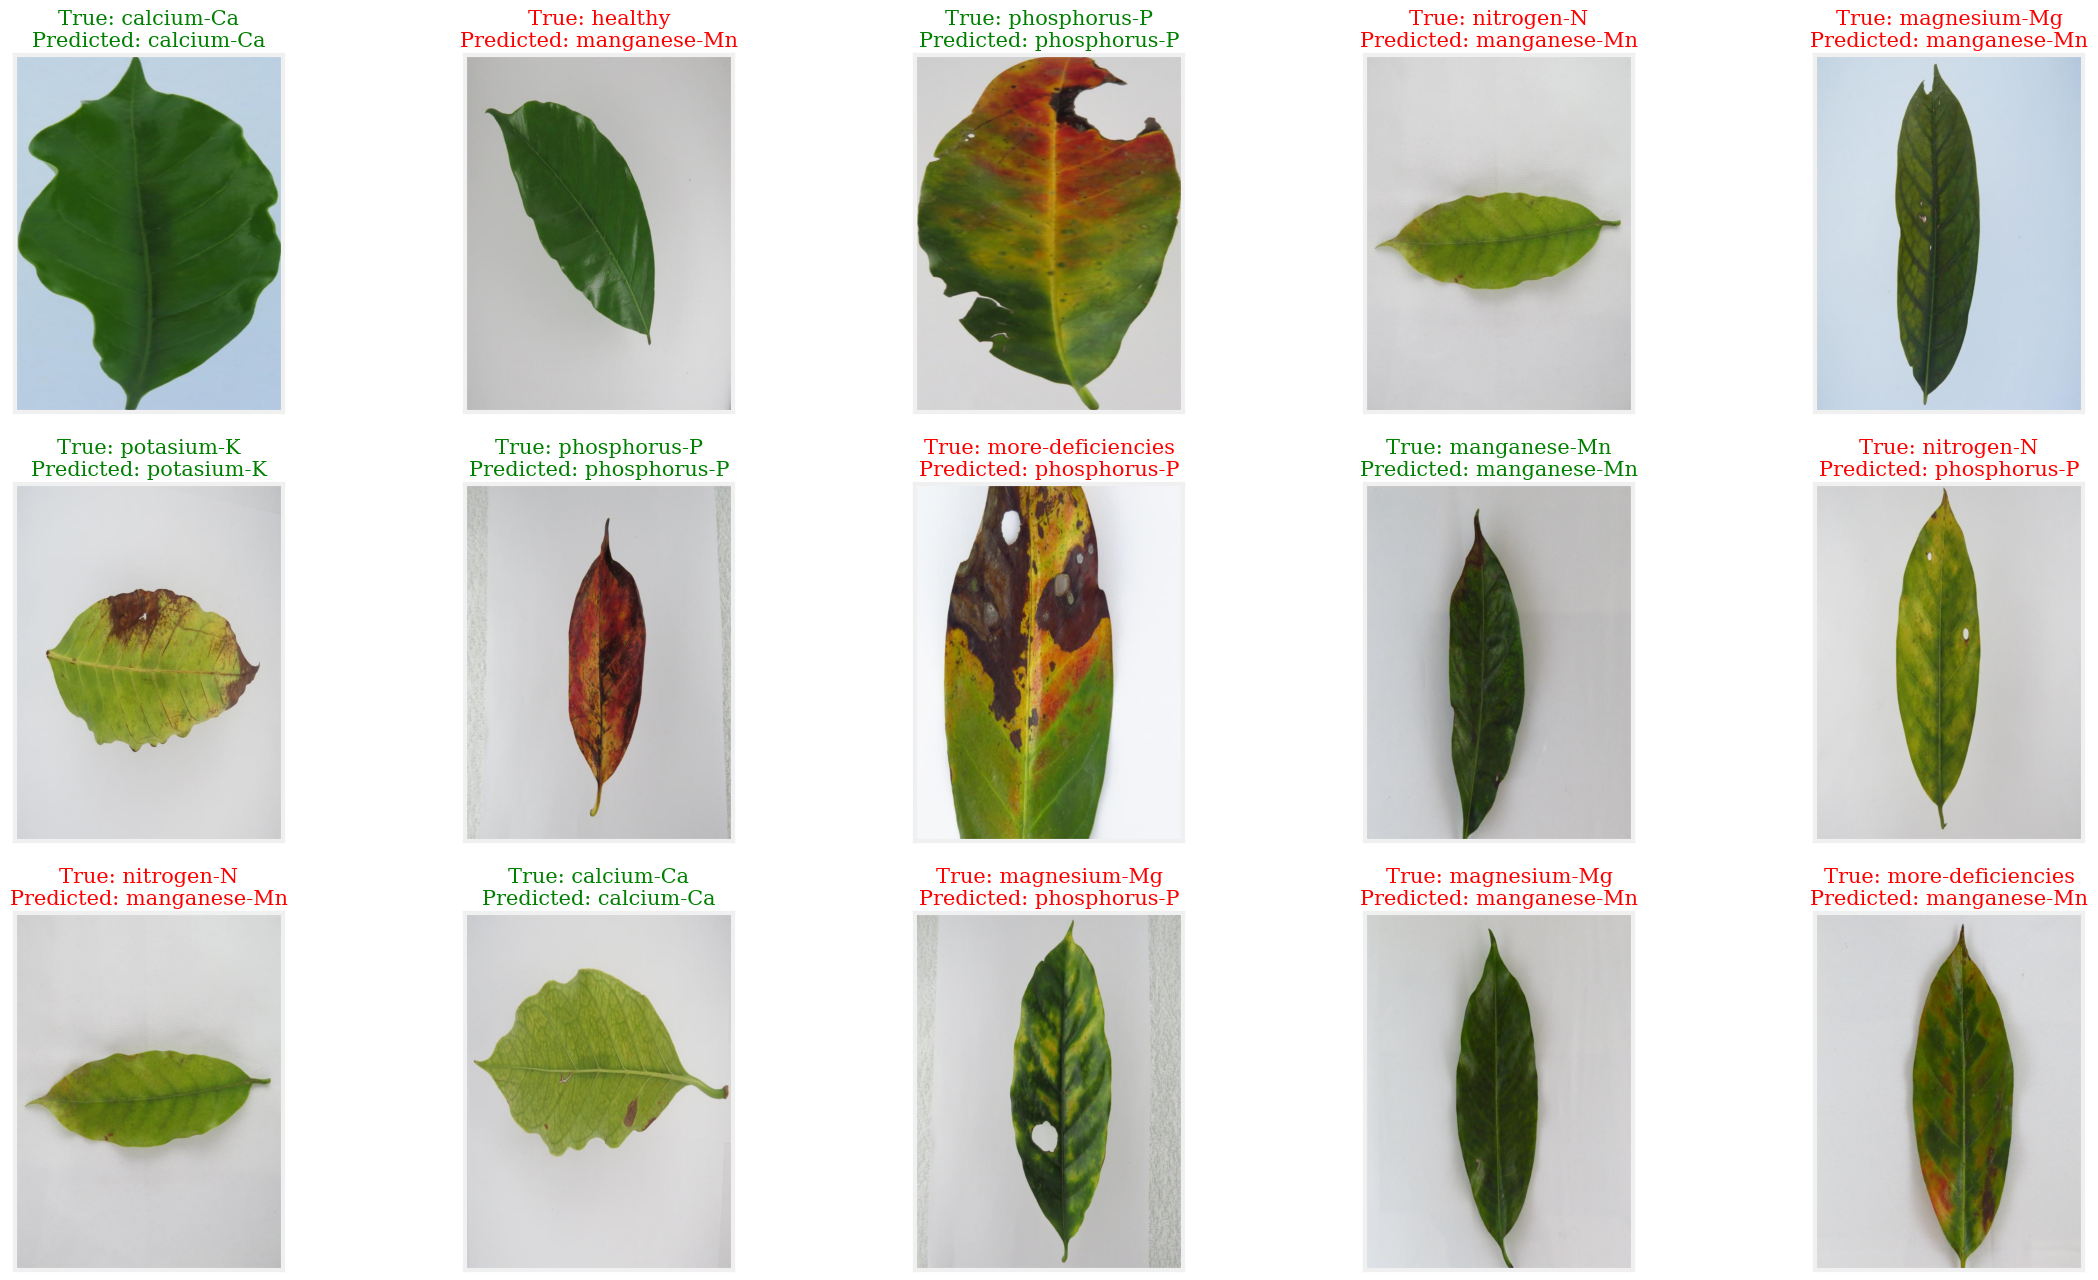

<Figure size 640x480 with 0 Axes>

In [23]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [24]:
import time

start_time = time.time()
model.predict(test_images)  # or any other input, just for demonstration
end_time = time.time()

print(f"Inference time: {end_time - start_time:.2f} seconds")

6/6 [==============================] - 1s 230ms/step
Inference time: 1.81 seconds


#Confusion Matrix

Class boron-B:
Precision: [0.12169312 0.76       1.        ]
Recall: [1.         0.82608696 0.        ]
Average Precision: 0.65

Class calcium-Ca:
Precision: [0.14814815 0.77419355 1.        ]
Recall: [1.         0.85714286 0.        ]
Average Precision: 0.68

Class healthy:
Precision: [0.00529101 1.        ]
Recall: [1. 0.]
Average Precision: 0.01

Class iron-Fe:
Precision: [0.03703704 1.        ]
Recall: [1. 0.]
Average Precision: 0.04

Class magnesium-Mg:
Precision: [0.07936508 1.         1.        ]
Recall: [1.         0.13333333 0.        ]
Average Precision: 0.20

Class manganese-Mn:
Precision: [0.06878307 0.12962963 1.        ]
Recall: [1.         0.53846154 0.        ]
Average Precision: 0.10

Class more-deficiencies:
Precision: [0.13756614 0.         1.        ]
Recall: [1. 0. 0.]
Average Precision: 0.14

Class nitrogen-N:
Precision: [0.0952381 1.       ]
Recall: [1. 0.]
Average Precision: 0.10

Class phosphorus-P:
Precision: [0.22222222 0.62295082 1.        ]
Recall: [1.     

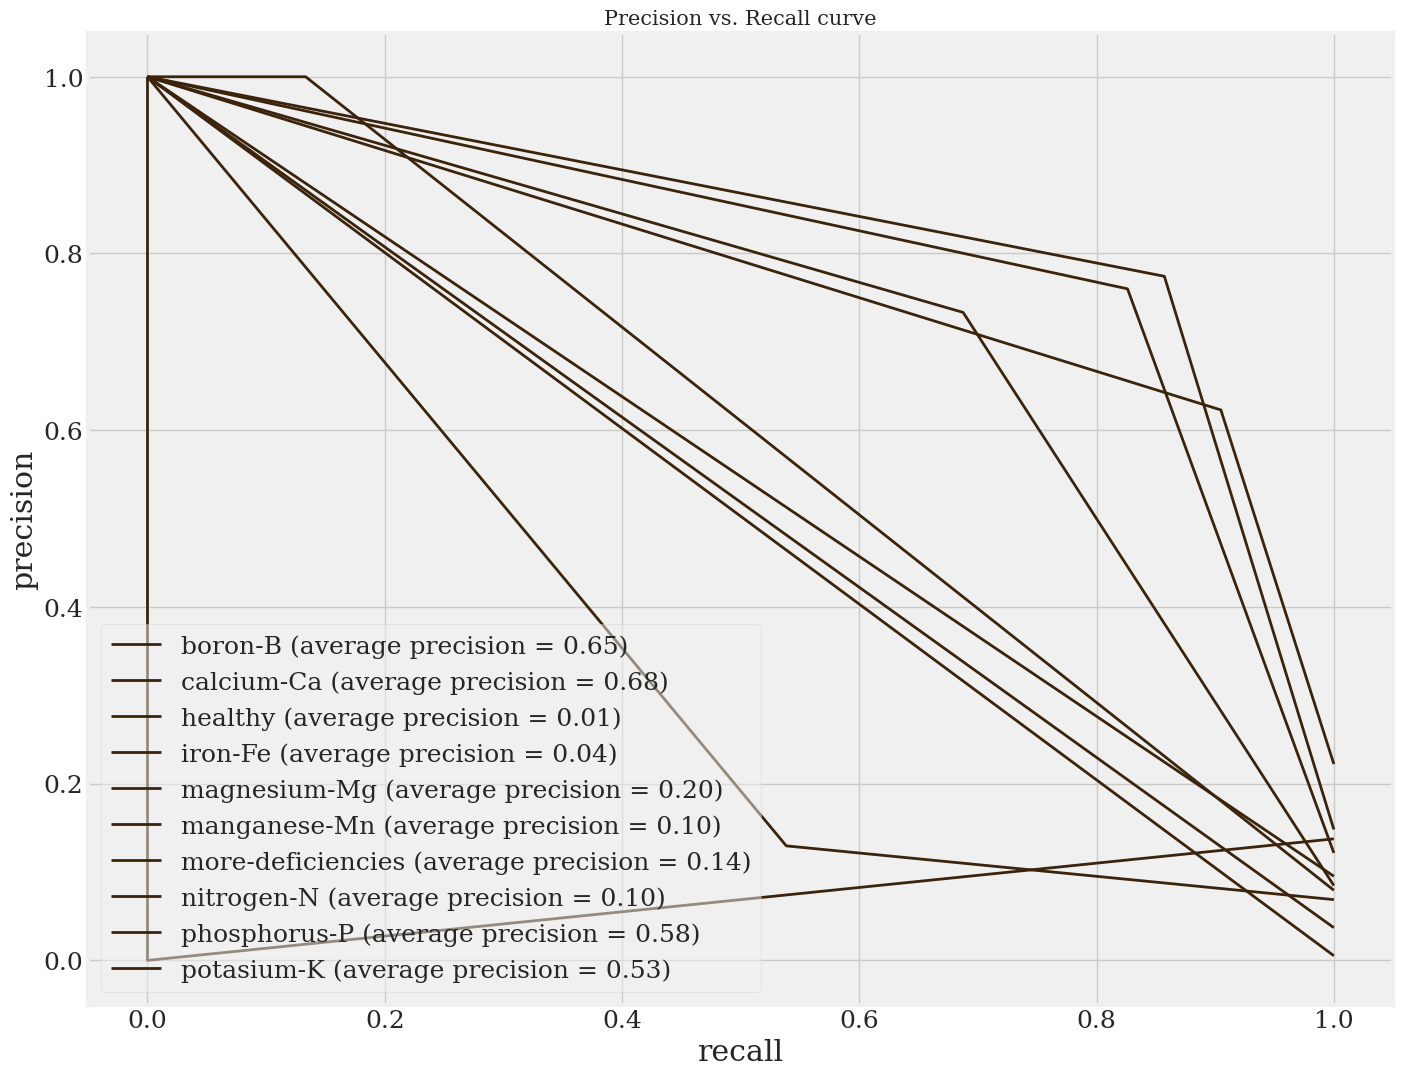

In [25]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Convert labels to one-hot encoding
lb = LabelBinarizer()
y_true_onehot = lb.fit_transform(test_df.Label)

# Convert predictions to one-hot encoding
y_pred_onehot = lb.transform(pred)

# For storing average precision for each class
average_precision = {}

# Get class names
class_names = lb.classes_

# Plot PR curve for each class
n_classes = y_true_onehot.shape[1]
plt.figure(figsize=(15, 12))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_onehot[:, i])
    average_precision[i] = average_precision_score(y_true_onehot[:, i], y_pred_onehot[:, i])

    # Printing the precision and recall values for each class using the actual class names
    print(f"Class {class_names[i]}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print(f"Average Precision: {average_precision[i]:.2f}\n")

    plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (average precision = {average_precision[i]:0.2f})')

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.grid(True)
plt.show()


In [26]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score     support
boron-B             0.760000  0.826087  0.791667   23.000000
calcium-Ca          0.774194  0.857143  0.813559   28.000000
healthy             0.000000  0.000000  0.000000    1.000000
iron-Fe             0.000000  0.000000  0.000000    7.000000
magnesium-Mg        1.000000  0.133333  0.235294   15.000000
manganese-Mn        0.129630  0.538462  0.208955   13.000000
more-deficiencies   0.000000  0.000000  0.000000   26.000000
nitrogen-N          0.000000  0.000000  0.000000   18.000000
phosphorus-P        0.622951  0.904762  0.737864   42.000000
potasium-K          0.733333  0.687500  0.709677   16.000000
accuracy            0.534392  0.534392  0.534392    0.534392
macro avg           0.402011  0.394729  0.349702  189.000000
weighted avg        0.495978  0.534392  0.473963  189.000000

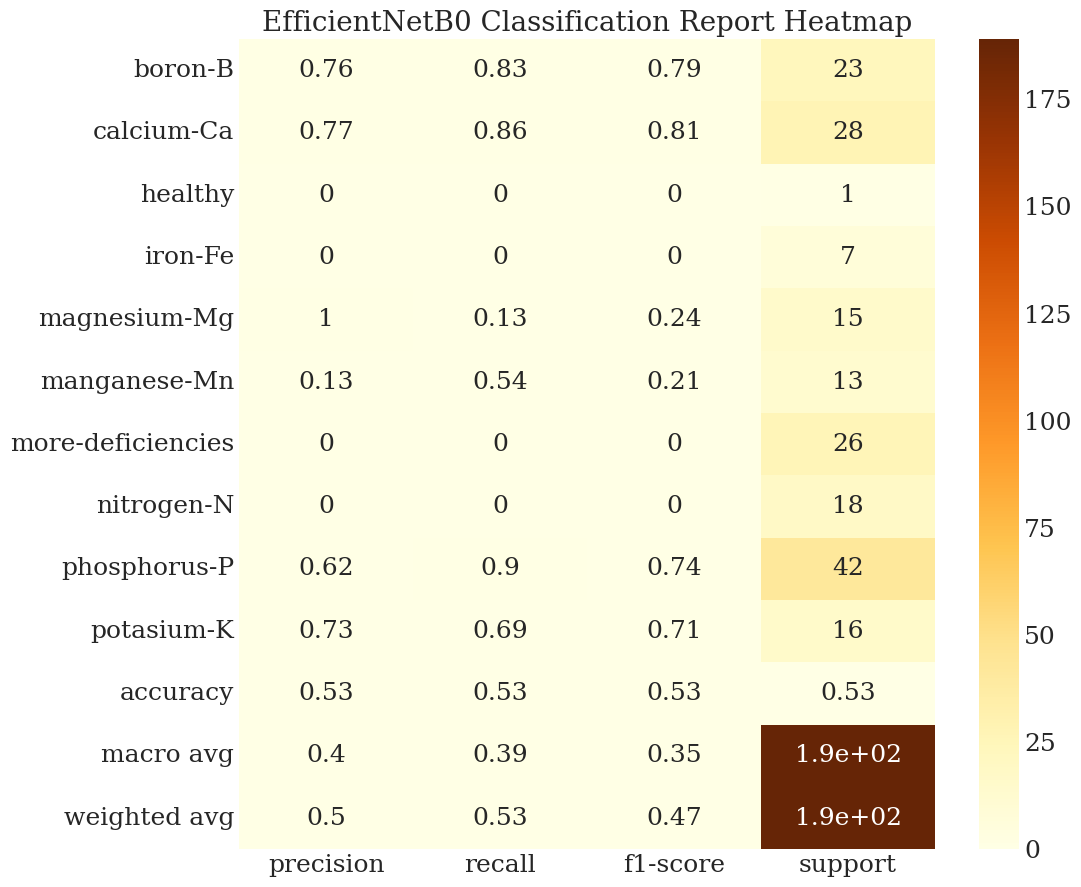

In [27]:
import textwrap
plt.figure(figsize=(10, 10))
sns.heatmap(df, annot=True, cmap='YlOrBr')
plt.title('EfficientNetB0 Classification Report Heatmap', fontsize=20)
plt.show()


In [28]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=12, norm=False, savefig=False):
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.YlGnBu) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="EfficientNetB0 Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=45, ha='right', fontsize=text_size)
    plt.yticks(fontsize=text_size)

    plt.grid(False)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

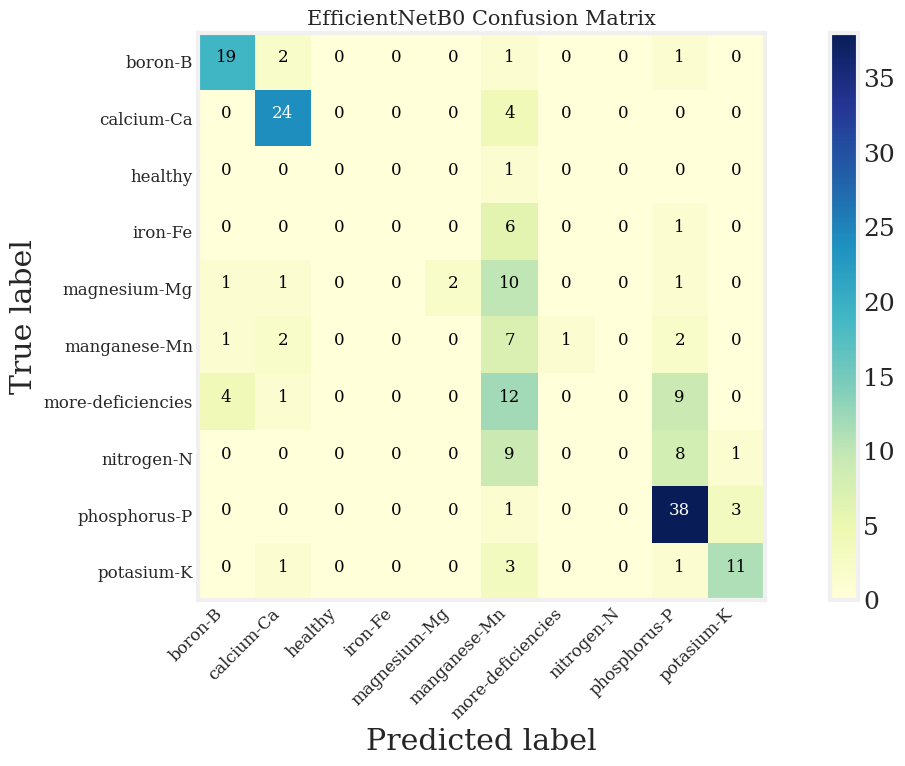

In [29]:
make_confusion_matrix(y_test, pred, list(labels.values()))

#Task 06: Discussion of the results and any observed trends or anomalies.

Some classes contain fewer images, which has negatively impacted the model's accuracy. In the future, we can consider removing some of these classes and retraining the model. We believe this will significantly improve its performance.